In [1]:
import geopandas as gpd
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Read the GeoJSON training file

gdf_train = gpd.read_file('data/train.geojson')
gdf_test = gpd.read_file('data/test.geojson')
# Display the first few rows of the GeoDataFrame
print(gdf_train.shape)
print(gdf_test.shape)

(20, 3)
(6, 3)


In [3]:
# Initialising the pystac library for accessing Plantery Computer's Blob storage containers 

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Function to pull satellite image data

def getimgdata(area_of_interest, time_of_interest):
    search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
    )

    items = search.item_collection()
    

    least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

    asset_href = least_cloudy_item.assets["visual"].href
    
    with rasterio.open(asset_href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        img_data = ds.read(window=aoi_window)
    
    return img_data.transpose(1, 2, 0) 


In [5]:
time_of_interest = "2022-01-01/2022-12-30"
area_of_interest = gdf_train.iloc[0]['geometry']

In [6]:
# Function to get Indexes data

def getIndexesdata(area_of_interest, time_of_interest):
    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

    search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
    )

    items = search.item_collection()
    item = min(items, key=lambda item: eo.ext(item).cloud_cover)


    red_band = item.get_assets()["B04"]  
    nir_band = item.get_assets()["B08"] 

    L = 0.5
    m = 0.5
    with rasterio.open(red_band.href) as red_src, rasterio.open(nir_band.href) as nir_src:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", red_src.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=red_src.transform, *warped_aoi_bounds)    
        red_data = red_src.read(window=aoi_window).astype(float)
        nir_data = nir_src.read(window=aoi_window).astype(float)


        ndvi = (nir_data - red_data) / (nir_data + red_data)
        savi = ((nir_data-red_data)/(nir_data + red_data + L))* (1+L)
        msavi = 2 * nir_data + 1 - np.sqrt((2 * nir_data + 1) ** 2 - 8 * (nir_data - red_data)) / 2
    return [ndvi[0], savi[0], msavi[0]]

In [7]:
# Setting the time of interest

time_of_interest = "2022-01-01/2022-12-30"

In [19]:
# Gathering satellite images for training data

img_data_train = [getimgdata(row['geometry'], time_of_interest) for _, row in gdf_train.iterrows()]
img_data_test =  [getimgdata(row['geometry'], time_of_interest) for _, row in gdf_test.iterrows()]

In [8]:
# Gathering NVDI, SAVI and MSAVI indexes for the images

index_data_train = [getIndexesdata(row['geometry'], time_of_interest)  for _, row in gdf_train.iterrows()]
index_data_test = [getIndexesdata(row['geometry'], time_of_interest) for _, row in gdf_test.iterrows()]

C:\Users\ajaym\AppData\Local\Temp\ipykernel_20088\4038932753.py:33: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_data - red_data) / (nir_data + red_data)


In [21]:
# Combining image data with indexes data
img_with_index_train = []
for i in range(len(img_data_train)):
    img = img_data_train[i]
    n, s, m = index_data_train[i]
    img_with_index_train.append([img, n, s, m])


In [22]:
img_with_index_test = []
for i in range(len(img_data_test)):
    img = img_data_test[i]
    n, s, m = index_data_test[i]
    img_with_index_test.append([img, n, s, m])


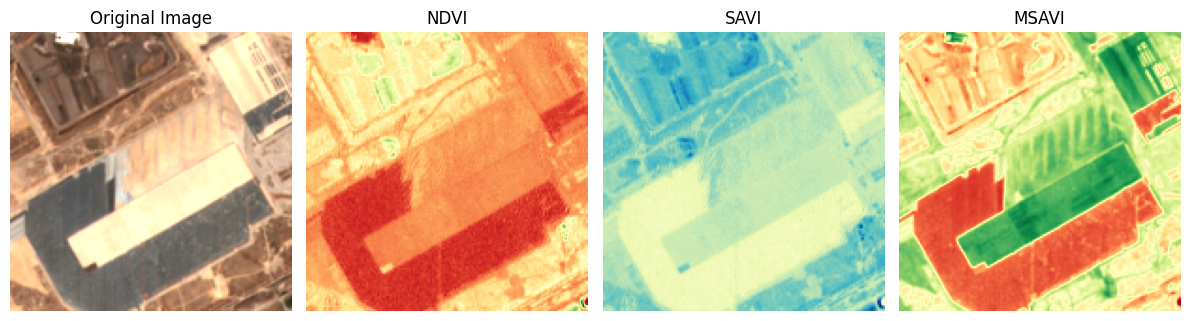

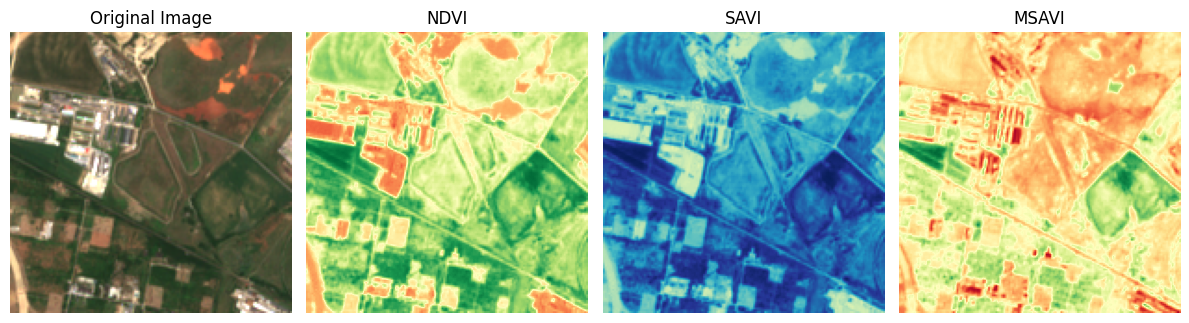

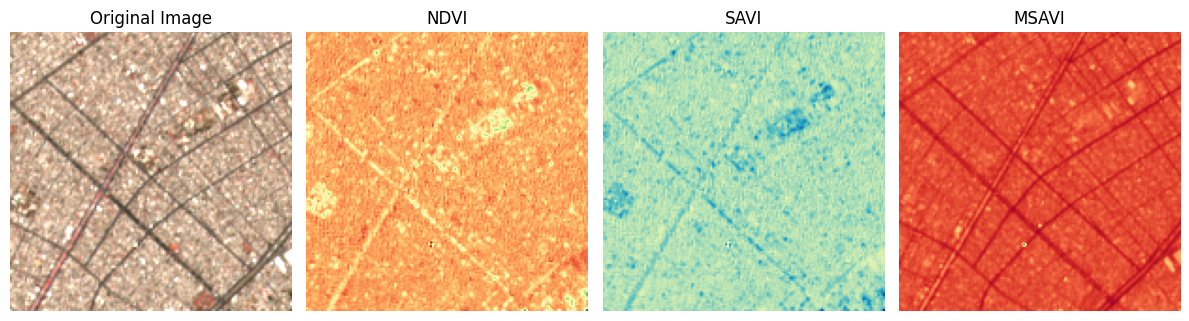

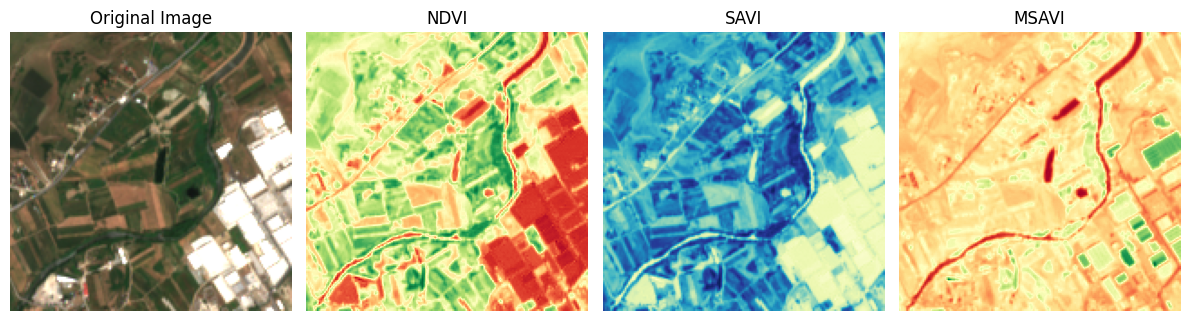

In [23]:
import matplotlib.pyplot as plt

def display_image_with_indices(data, index=0):
    original_img, ndvi, savi, msavi = data[index]

    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    # NDVI
    plt.subplot(1, 4, 2)
    plt.title("NDVI")
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.axis('off')

    # SAVI
    plt.subplot(1, 4, 3)
    plt.title("SAVI")
    plt.imshow(savi, cmap='YlGnBu')
    plt.axis('off')

    # MSAVI
    plt.subplot(1, 4, 4)
    plt.title("MSAVI")
    plt.imshow(msavi, cmap='RdYlGn')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the first image with indices
display_image_with_indices(img_with_index_train, index=0)
display_image_with_indices(img_with_index_train, index=5)
display_image_with_indices(img_with_index_train, index=10)
display_image_with_indices(img_with_index_train, index=19)

In [24]:
from PIL import Image
import numpy as np

def resize_images(img_data, target_size=(128, 128)):
    """
    Resize a list of image-label pairs to the target size.

    Args:
        img_data (list): A list of image-label pairs, where each pair is [image, label].
        target_size (tuple): The target size for the images in the format (width, height).

    Returns:
        list: A list of resized image-label pairs.
    """
    resized_img_data = []

    for img in img_data:
        pil_image = Image.fromarray(img)
        pil_image = pil_image.resize(target_size)
        resized_img = np.array(pil_image)
        resized_img_data.append([resized_img])

    return resized_img_data

resized_data_train = resize_images(img_data_train, target_size=(128, 128))
resized_data_test = resize_images(img_data_test, target_size=(128, 128))

In [31]:
resized_data_train[0][0][3]

array([[133, 101,  89],
       [131, 102,  82],
       [106,  76,  64],
       [112,  83,  66],
       [115,  84,  70],
       [116,  86,  71],
       [121,  88,  65],
       [122,  86,  64],
       [147,  99,  74],
       [175, 119,  88],
       [160, 111,  82],
       [123,  88,  68],
       [ 92,  66,  53],
       [ 76,  55,  45],
       [ 81,  62,  48],
       [100,  74,  58],
       [126,  98,  80],
       [139, 107,  92],
       [132, 106,  85],
       [115,  85,  76],
       [156, 133, 117],
       [226, 212, 187],
       [204, 176, 180],
       [251, 250, 242],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [242, 229, 217],
       [226, 195, 163],
       [225, 205, 167],
       [180, 147, 127],
       [178, 144, 121],
       [131, 105,  86],
       [ 83,  62,  47],
       [ 84,  61,  47],
       [ 99,  72,  55],
       [110,  80,  63],
       [104,  76,  59],
       [106,  76,  61],
       [122,  86

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define your CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Flatten(),


    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])  

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])



images_train = [pair[0] for pair in resized_data_train]
labels_train = [row['label'] for _, row in gdf_train.iterrows()]


images_train = np.array(images_train)
labels_train = np.array(labels_train)


images_train = images_train / 255.0


model.fit(images_train, labels_train, epochs=10, batch_size=32)



images_test = [pair[0] for pair in resized_data_test]
labels_test = [row['label'] for _, row in gdf_test.iterrows()]


images_test = np.array(images_test)
labels_test = np.array(labels_test)


images_test = images_test / 255.0


test_loss, test_accuracy = model.evaluate(images_test, labels_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6928 - accuracy: 0.4500
Epoch 2/10
1/1 [==============================] - 0s 248ms/step - loss: 0.8625 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 238ms/step - loss: 0.8478 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 230ms/step - loss: 0.6943 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 223ms/step - loss: 0.6320 - accuracy: 0.8500
Epoch 6/10
1/1 [==============================] - 0s 209ms/step - loss: 0.6305 - accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 0s 216ms/step - loss: 0.5460 - accuracy: 0.9500
Epoch 8/10
1/1 [==============================] - 0s 206ms/step - loss: 0.5202 - accuracy: 0.7500
Epoch 9/10
1/1 [==============================] - 0s 206ms/step - loss: 0.4604 - accuracy: 0.7500
Epoch 10/10
1/1 [==============================] - 0s 172ms/step - loss: 0.6648 - accuracy: 0.6667
Test Accuracy: 0.66666

1/1 [==============================] - 0s 31ms/step


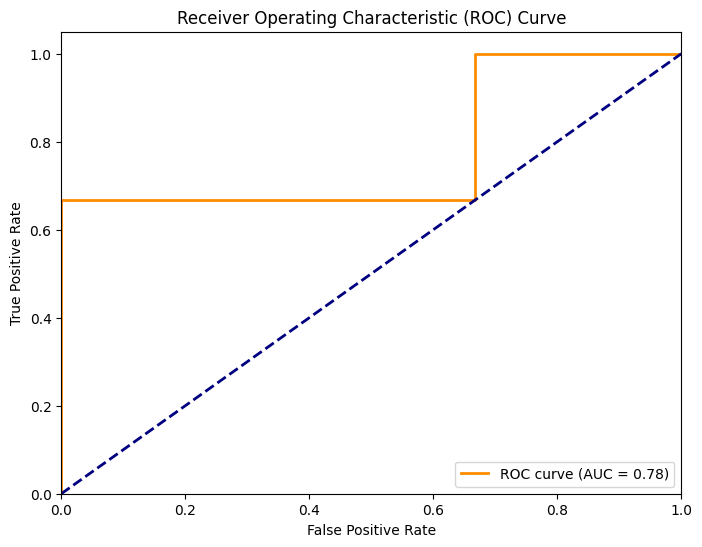

Precision: 1.0
Recall: 0.3333333333333333
ROC-AUC: 0.7777777777777778


In [34]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you already have model predictions
predictions = model.predict(images_test)

# Convert predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(labels_test, binary_predictions)
recall = recall_score(labels_test, binary_predictions)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, predictions)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(labels_test, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Precision:", precision)
print("Recall:", recall)
print("ROC-AUC:", roc_auc)
